# Comparison Explainability Constraints

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from models.mnist_cnn import CNN3b, CNN4b
from loaders.mnist_loader import MNIST_data, FashionMNIST_data
from torch.optim import Adam, Adadelta
from losses.losses import FidelityConstraint, StandardCrossEntropy, GradientRegularization, SmoothnessConstraint, GeneralizabilityConstraint
from metrics.metrics import accuracy, MoRF, faithfulness, complexity
from torch.nn import Softmax 
from captum.attr import Saliency, LRP, Occlusion, IntegratedGradients,GradientShap, LayerGradCam, LayerAttribution, KernelShap 
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, Sequential, Dropout, Conv2d, MaxPool2d, Module, BatchNorm2d, Flatten
from losses.losses import StandardCrossEntropy
from train import train_xai, train_base
import torchvision
from torch.autograd import Variable
from utils.utils import input_grads, integrated_grads, AddSquareMask, AddGaussianNoise
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import auc
import json
import pandas as pd
import seaborn as sns
import os

In [2]:
outfolder = r".\results\plots"

In [3]:
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [4]:
plt.rc("font", size=24)
plt.rc("axes", labelsize=24)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=22)
plt.rc("lines", markersize=20)
plt.rcParams['axes.grid'] = True

In [5]:
loaders = MNIST_data(batch_size = 60)

In [6]:
bmodel = torch.load(r".\results\final\mnist_cnn_base_9872.pt")
bmodel.eval()
fmodel = torch.load(r".\results\final\mnist_cnn_fidelity_9899.pt")
fmodel.eval()
rmodel = torch.load(r".\results\final\mnist_cnn_gradreg_9852.pt")
rmodel.eval()
lmodel = torch.load(r".\results\final\mnist_cnn_locality_9878.pt")
lmodel.eval()
stmodel = torch.load(r".\results\final\mnist_cnn_smoothness_9855.pt")
stmodel.eval()
symodel = torch.load(r".\results\final\mnist_cnn_symmetry_9854.pt")
symodel.eval()
cmodel = torch.load(r".\results\final\mnist_cnn_consistency_9873.pt")
cmodel.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=784, out_features=10, bias=True)
)

In [7]:
fid_c1 =  list(bmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
fw = pd.DataFrame({"weights": fid_c1 })

base_c1 =  list(fmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
bw = pd.DataFrame({"weights": base_c1 })

gradreg_c1 =  list(rmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
rw = pd.DataFrame({"weights": gradreg_c1 })


loc_c1 = list(lmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
lw = pd.DataFrame({"weights": loc_c1 })

smt_c1 = list(stmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
smtw = pd.DataFrame({"weights": smt_c1 })

sym_c1 = list(symodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
symw = pd.DataFrame({"weights": sym_c1 })

cons_c1 =  list(cmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
conw = pd.DataFrame({"weights": cons_c1 })

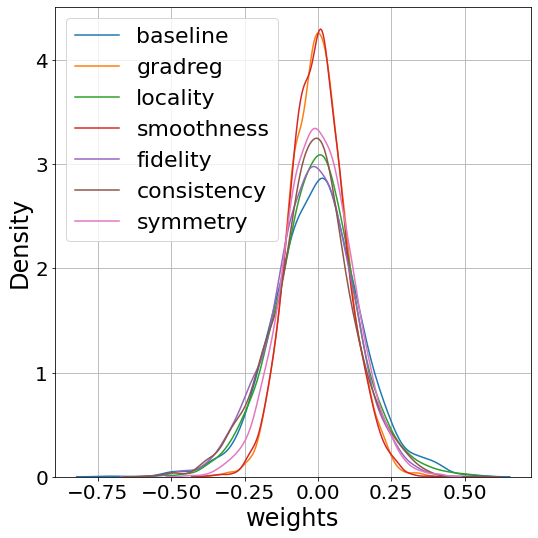

In [8]:
plt.figure(figsize=(8,8))
sns.kdeplot(data=bw, x="weights", label="baseline")
sns.kdeplot(data=rw, x="weights", label="gradreg")
sns.kdeplot(data=lw, x="weights", label="locality")
sns.kdeplot(data=smtw, x="weights", label="smoothness")
sns.kdeplot(data=fw, x="weights", label="fidelity")
sns.kdeplot(data=conw, x="weights", label="consistency")
sns.kdeplot(data=symw, x="weights", label="symmetry")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "weights_distr.png"), bbox_inches="tight", dpi=1100)
plt.show()

# Training Accuracy and Constraints Optimization

In [8]:
fidacc = np.load(r".\results\final\acc_fidelity.npy")
baseacc = np.load(r".\results\final\acc_base.npy")
gregacc = np.load(r".\results\final\acc_gradreg.npy")
locacc = np.load(r".\results\final\acc_locality.npy")
smootacc = np.load(r".\results\final\acc_smoothness.npy")
symacc = np.load(r".\results\final\acc_symmetry.npy")
consacc = np.load(r".\results\final\acc_consistency.npy")

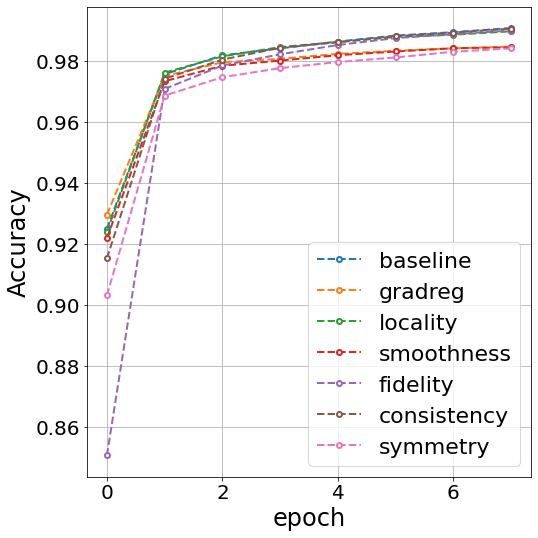

In [9]:
plt.figure(figsize=(8,8))
plt.plot(range(len(fidacc)), baseacc, label="baseline", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(gregacc)), gregacc, label="gradreg", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(fidacc)), locacc, label="locality", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(fidacc)), smootacc, label="smoothness", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(fidacc)), fidacc, label="fidelity", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(consacc)), consacc, label="consistency", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(symacc)), symacc, label="symmetry", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(outfolder, "all_accuracy.png"), bbox_inches="tight", dpi=1100)
plt.show()
plt.show()

In [10]:
f = open(r".\results\baseline_constraints.json")
data = json.load(f)

In [47]:
gregcons = np.load(r".\results\final\xloss_gradreg.npy")
loccons = np.load(r".\results\final\xloss_locality.npy")
fidcons = np.load(r".\results\final\xloss_fidelity.npy")
symcons = np.load(r".\results\final\xloss_symmetry.npy")
smtcons = np.load(r".\results\final\xloss_smoothness.npy")
concons = np.load(r".\results\final\xloss_consistency.npy")

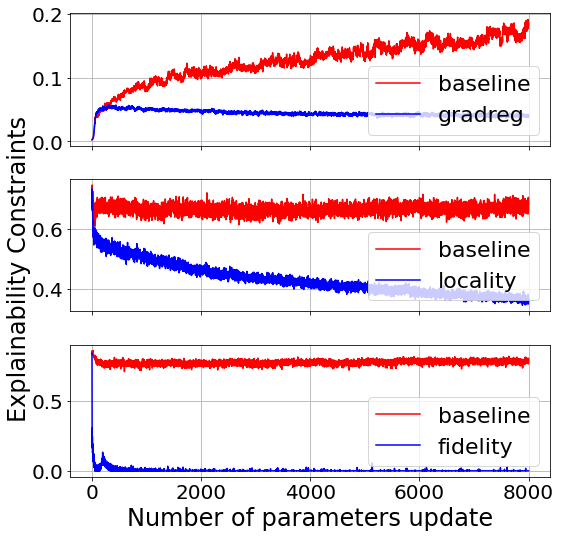

In [52]:
fig, axs = plt.subplots(3, sharex=True, figsize=(8,8))
fig.text(0.003, 0.5, 'Explainability Constraints', va='center', rotation='vertical')
#fig.suptitle('Sharing both axes')
axs[0].plot(range(len(data["gradreg"])), data["gradreg"], label="baseline", color="red")
axs[0].plot(range(len(gregcons)), gregcons, label="gradreg", color="blue")
axs[1].plot(range(len(data["loc"])), data["loc"], label="baseline", color="red")
axs[1].plot(range(len(loccons)), loccons, label="locality", color="blue")
axs[2].plot(range(len(data["fid"])), data["fid"], label="baseline", color="red")
axs[2].plot(range(len(fidcons)), fidcons, label="fidelity", color="blue")
axs[2].set_xlabel("Number of parameters update")
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "losses1.png"), bbox_inches="tight", dpi=1100)
plt.show()

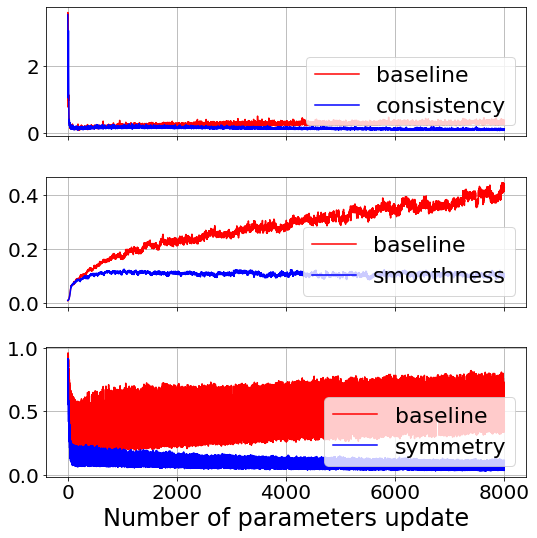

In [51]:
fig, axs = plt.subplots(3, sharex=True, figsize=(8,8))
#fig.text(0.01, 0.5, 'Explainability Constraints', va='center', rotation='vertical')
#fig.suptitle('Sharing both axes')
axs[0].plot(range(len(data["cons"])), data["cons"], label="baseline", color="red")
axs[0].plot(range(len(concons)), concons, label="consistency", color="blue")
axs[1].plot(range(len(data["smooth"])), data["smooth"], label="baseline", color="red")
axs[1].plot(range(len(smtcons)), smtcons, label="smoothness", color="blue")
axs[2].plot(range(len(data['sym'])), 1-np.array(data["sym"]), label="baseline", color="red")
axs[2].plot(range(len(symcons)), symcons, label="symmetry", color="blue")
axs[2].set_xlabel("Number of parameters update")
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "losses2.png"), bbox_inches="tight", dpi=1100)
plt.show()

# Saliency Metrics

## MoRF

In [25]:
perc = list(sorted(np.linspace(0, 100, num=20).astype(int), reverse=True))

In [10]:
bdrop0 = MoRF(bmodel, loaders, perc, method="grad")
rdrop0 = MoRF(rmodel, loaders, perc, method="grad")
cdrop0 = MoRF(cmodel, loaders, perc, method="grad")
sydrop0 = MoRF(symodel, loaders, perc, method="grad")
fdrop0 = MoRF(fmodel, loaders, perc, method="grad")
stdrop0 = MoRF(stmodel, loaders, perc, method="grad")
ldrop0 = MoRF(lmodel, loaders, perc, method="grad")

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\metrics\metrics.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  d = softm(model(images.cuda()*maskpos.cuda())).cpu().detach().numpy()[0,torch.argmax(softm(model(images.cuda())))]/torch.max(softm(model(images.cuda()))).cpu().detach().numpy()


In [11]:
print('Baseline Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-bdrop0)))
print('Fidelity Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-fdrop0)))
print('GradReg Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-rdrop0)))
print('Consistency Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-cdrop0)))
print('Symmetry Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-sydrop0)))
print('Smoothness Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-stdrop0)))
print('Locality Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-ldrop0)))

Baseline Model AUC : 0.6960593325195142
Fidelity Model AUC : 0.8267144357058736
GradReg Model AUC : 0.6581631356134522
Consistency Model AUC : 0.6263238189389412
Symmetry Model AUC : 0.8363682176859427
Smoothness Model AUC : 0.6883295440770604
Locality Model AUC : 0.8464486280399096


In [12]:
bdrop1 = MoRF(bmodel, loaders, perc, method="grad",  model_attr=symodel)
rdrop1 = MoRF(rmodel, loaders, perc, method="grad",  model_attr=symodel)
cdrop1 = MoRF(cmodel, loaders, perc, method="grad",  model_attr=symodel)
sydrop1 = MoRF(symodel, loaders, perc, method="grad",  model_attr=symodel)
fdrop1 = MoRF(fmodel, loaders, perc, method="grad",  model_attr=symodel)
stdrop1 = MoRF(stmodel, loaders, perc, method="grad",  model_attr=symodel)
ldrop1 = MoRF(lmodel, loaders, perc, method="grad",  model_attr=symodel)

In [13]:
print('Baseline Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-bdrop1)))
print('Fidelity Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-fdrop1)))
print('GradReg Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-rdrop1)))
print('Consistency Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-cdrop1)))
print('Symmetry Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-sydrop1)))
print('Smoothness Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-stdrop1)))
print('Locality Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-ldrop1)))

Baseline Model AUC : 0.8261769906433445
Fidelity Model AUC : 0.8310213002799826
GradReg Model AUC : 0.8240709079901756
Consistency Model AUC : 0.8263498900792386
Symmetry Model AUC : 0.8363682176859427
Smoothness Model AUC : 0.8263824119527271
Locality Model AUC : 0.8365926310396803


In [19]:
bdrop2 = MoRF(bmodel, loaders, perc, method="grad",  model_attr=bmodel)
rdrop2 = MoRF(rmodel, loaders, perc, method="grad",  model_attr=bmodel)
cdrop2 = MoRF(cmodel, loaders, perc, method="grad",  model_attr=bmodel)
sydrop2 = MoRF(symodel, loaders, perc, method="grad",  model_attr=bmodel)
fdrop2 = MoRF(fmodel, loaders, perc, method="grad",  model_attr=bmodel)
stdrop2 = MoRF(stmodel, loaders, perc, method="grad",  model_attr=bmodel)
ldrop2 = MoRF(lmodel, loaders, perc, method="grad",  model_attr=bmodel)

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\metrics\metrics.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  d = softm(model(images.cuda()*maskpos.cuda())).cpu().detach().numpy()[0,torch.argmax(softm(model(images.cuda())))]/torch.max(softm(model(images.cuda()))).cpu().detach().numpy()


In [20]:
print('Baseline Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-bdrop2)))
print('Fidelity Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-fdrop2)))
print('GradReg Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-rdrop2)))
print('Consistency Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-cdrop2)))
print('Symmetry Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-sydrop2)))
print('Smoothness Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-stdrop2)))
print('Locality Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-ldrop2)))

Baseline Model AUC : 0.696059215705632
Fidelity Model AUC : 0.6692288577130922
GradReg Model AUC : 0.5655589044991609
Consistency Model AUC : 0.627573994752486
Symmetry Model AUC : 0.6079314592861131
Smoothness Model AUC : 0.5914111342974039
Locality Model AUC : 0.6801035406375047


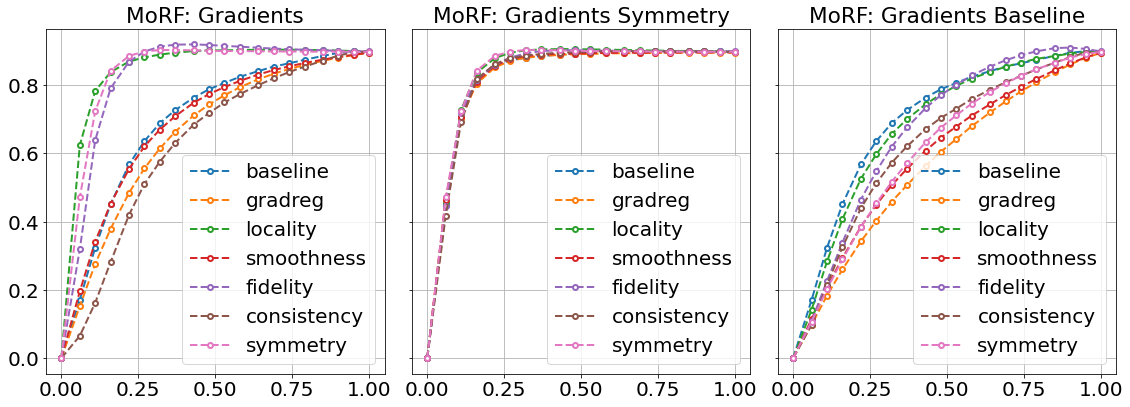

In [23]:
plt.rc("font", size=18)
plt.rc("axes", labelsize=22)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)
plt.rc("lines", markersize=20)

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,6))
axs[0].plot(1-np.array(perc)/100, 1-bdrop0, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-rdrop0, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-ldrop0, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-stdrop0, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-fdrop0, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-cdrop0, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-sydrop0, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-bdrop1, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-rdrop1, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-ldrop1, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-stdrop1, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-fdrop1, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-cdrop1, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-sydrop1, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-bdrop2, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-rdrop2, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-ldrop2, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-stdrop2, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-fdrop2, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-cdrop2, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-sydrop2, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].set_title("MoRF: Gradients")
axs[0].legend(loc="lower right")
axs[1].set_title("MoRF: Gradients Symmetry")
axs[1].legend(loc="lower right")
axs[2].set_title("MoRF: Gradients Baseline")
axs[2].legend(loc="lower right")
#axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "morf_grad.png"), bbox_inches="tight", dpi=1100)
plt.show()


#plt.title("MoRF: Gradients")
#plt.plot(1-np.array(perc)/100, 1-bdrop, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-rdrop, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-ldrop, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-stdrop, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-fdrop, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-cdrop, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-sydrop, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.xlabel("% features removed")
#plt.ylabel("Avg error")
#plt.grid(True)
#plt.legend()
#plt.savefig(os.path.join(outfolder, "morf_grad.png"), bbox_inches="tight", dpi=1100)
#plt.show()

## Faithfulness

In [27]:
bfaith = faithfulness(bmodel, loaders, perc)
cfaith = faithfulness(cmodel, loaders, perc)
ffaith = faithfulness(fmodel, loaders, perc)
lfaith = faithfulness(lmodel, loaders, perc)
syfaith = faithfulness(symodel, loaders, perc)
stfaith = faithfulness(stmodel, loaders, perc)
rfaith = faithfulness(rmodel, loaders, perc)

In [10]:
print('Baseline faithfulness : {}'.format(np.mean(bfaith)))
print('Fidelity faithfulness: {}'.format(np.mean(ffaith)))
print('GradReg faithfulness : {}'.format(np.mean(rfaith)))
print('Consistency faithfulness : {}'.format(np.mean(cfaith)))
print('Symmetry faithfulness : {}'.format(np.mean(syfaith)))
print('Smoothness faithfulness : {}'.format(np.mean(stfaith)))
print('Locality faithfulness : {}'.format(np.mean(lfaith)))

Baseline faithfulness : 0.8008615281357718
Fidelity faithfulness: 0.797446508528459
GradReg faithfulness : 0.909518790644374
Consistency faithfulness : 0.8224188734807852
Symmetry faithfulness : 0.8197843838408855
Smoothness faithfulness : 0.8943684975149523
Locality faithfulness : 0.7072774143737556


## Complexity

In [55]:
bcomp = complexity(bmodel, loaders)
ccomp = complexity(cmodel, loaders)
sycomp = complexity(symodel, loaders)
stcomp = complexity(stmodel, loaders)
fcomp = complexity(fmodel, loaders)
lcomp = complexity(lmodel, loaders)
rcomp = complexity(rmodel, loaders)

In [56]:
print('Baseline complexity : {}'.format(bcomp))
print('Fidelity complexity : {}'.format(fcomp))
print('GradReg complexity : {}'.format(rcomp))
print('Consistency complexity : {}'.format(ccomp))
print('Symmetry complexity : {}'.format(sycomp))
print('Smoothness complexity : {}'.format(stcomp))
print('Locality complexity : {}'.format(lcomp))

Baseline complexity : 4.399892330169678
Fidelity complexity : 4.304908752441406
GradReg complexity : 4.327702522277832
Consistency complexity : 4.376689910888672
Symmetry complexity : 4.229517936706543
Smoothness complexity : 4.329282760620117
Locality complexity : 4.347668647766113


## ROAR and robustness under perturbations 


In [8]:
perc = [0, 0.2, 0.5, 0.8, 0.9]
std = [0, 0.1, 0.5, 1.0, 1.5]
max_size = [0, 6, 8, 10, 12]

In [9]:
broar = np.load(r".\results\final\roar_base.npy")
froar = np.load(r".\results\final\roar_fidelity.npy")
rroar = np.load(r".\results\final\roar_gradreg.npy")
lroar = np.load(r".\results\final\roar_locality.npy")
stroar = np.load(r".\results\final\roar_smoothness.npy")
syroar = np.load(r".\results\final\roar_symmetry.npy")
croar =  np.load(r".\results\final\roar_consistency.npy")

In [9]:
bblock = np.load(r".\results\final\block_baseline.npy")
fblock = np.load(r".\results\final\block_fidelity.npy")
rblock = np.load(r".\results\final\block_gradreg.npy")
lblock = np.load(r".\results\final\block_locality.npy")
stblock = np.load(r".\results\final\block_smoothness.npy")
syblock = np.load(r".\results\final\block_symmetry.npy")
cblock =  np.load(r".\results\final\block_consistency.npy")

In [10]:
bgauss = np.load(r".\results\final\gauss_baseline.npy")
fgauss = np.load(r".\results\final\gauss_fidelity.npy")
rgauss = np.load(r".\results\final\gauss_gradreg.npy")
lgauss = np.load(r".\results\final\gauss_locality.npy")
stgauss = np.load(r".\results\final\gauss_smoothness.npy")
sygauss = np.load(r".\results\final\gauss_symmetry.npy")
cgauss =  np.load(r".\results\final\gauss_consistency.npy")

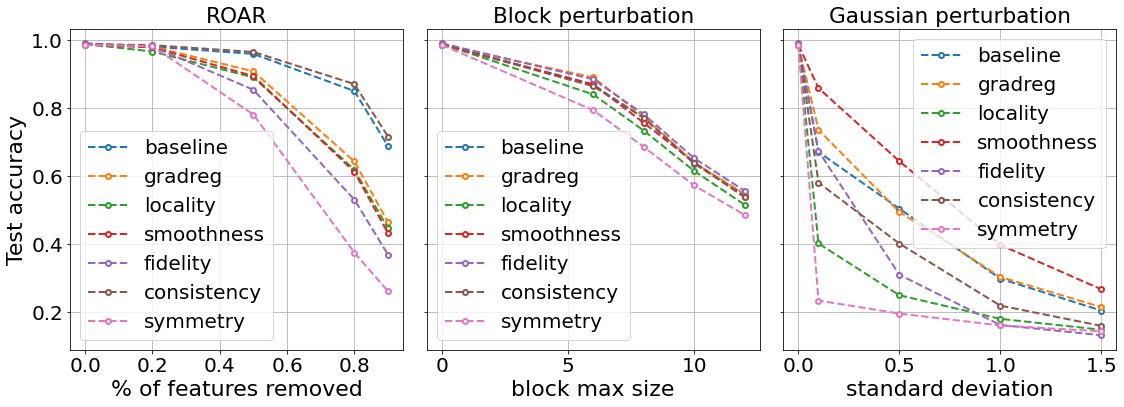

In [15]:
plt.rc("font", size=18)
plt.rc("axes", labelsize=22)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)
plt.rc("lines", markersize=20)

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,6))
axs[0].plot(perc, broar, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, rroar, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, lroar, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, stroar, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, froar, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, croar, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, syroar, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, bblock, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, rblock, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, lblock, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, stblock, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, fblock, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, cblock, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, syblock, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, bgauss, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, rgauss, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, lgauss, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, stgauss, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, fgauss, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, cgauss, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, sygauss, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].set_title("ROAR")
axs[0].legend(loc="lower left")
axs[0].set_xlabel("% of features removed")
axs[0].set_ylabel("Test accuracy")
axs[1].set_title("Block perturbation")
axs[1].legend(loc="lower left")
axs[1].set_xlabel("block max size")
axs[2].set_title("Gaussian perturbation")
axs[2].legend(loc="upper right")
axs[2].set_xlabel("standard deviation")
#axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "roar_pert.png"), bbox_inches="tight", dpi=1100)
plt.show()


In [23]:
print('Baseline Model ROAR : {}'.format(auc(perc, broar)))
print('Fidelity Model ROAR : {}'.format(auc(perc, froar)))
print('GradReg Model ROAR : {}'.format(auc(perc, rroar)))
print('Smoothness Model ROAR : {}'.format(auc(perc, stroar)))
print('Locality Model ROAR : {}'.format(auc(perc, lroar)))
print('Symmetry Model ROAR : {}'.format(auc(perc, syroar)))
print('Consistency Model ROAR : {}'.format(auc(perc, croar)))


Baseline Model ROAR : 0.8355049999999999
Fidelity Model ROAR : 0.7244
GradReg Model ROAR : 0.7674100000000001
Smoothness Model ROAR : 0.755015
Locality Model ROAR : 0.75294
Symmetry Model ROAR : 0.6657299999999999
Consistency Model ROAR : 0.84387


In [11]:
print('Baseline Model Gauss : {}'.format(auc(std, bgauss)))
print('Fidelity Model Gauss : {}'.format(auc(std, fgauss)))
print('GradReg Model Gauss : {}'.format(auc(std, rgauss)))
print('Smoothness Model Gauss : {}'.format(auc(std, stgauss)))
print('Locality Model Gauss : {}'.format(auc(std, lgauss)))
print('Symmetry Model Gauss : {}'.format(auc(std, sygauss)))
print('Consistency Model Gauss : {}'.format(auc(std, cgauss)))


Baseline Model Gauss : 0.6431300000000001
Fidelity Model Gauss : 0.47013499999999997
GradReg Model Gauss : 0.6602299999999999
Smoothness Model Gauss : 0.8181200000000002
Locality Model Gauss : 0.388
Symmetry Model Gauss : 0.310655
Consistency Model Gauss : 0.5234


In [12]:
print('Baseline Model Block : {}'.format(auc(max_size, bblock)))
print('Fidelity Model Block : {}'.format(auc(max_size, fblock)))
print('GradReg Model Block : {}'.format(auc(max_size, rblock)))
print('Smoothness Model Block : {}'.format(auc(max_size, stblock)))
print('Locality Model Block : {}'.format(auc(max_size, lblock)))
print('Symmetry Model Block : {}'.format(auc(max_size, syblock)))
print('Consistency Model Block : {}'.format(auc(max_size, cblock)))


Baseline Model Block : 9.788
Fidelity Model Block : 9.9278
GradReg Model Block : 9.886899999999999
Smoothness Model Block : 9.7637
Locality Model Block : 9.531400000000001
Symmetry Model Block : 9.1271
Consistency Model Block : 9.7714


## Visual Comparison of Improved Saliency Maps

In [68]:
bgrad = Saliency(bmodel)
rgrad = Saliency(rmodel)
lgrad = Saliency(lmodel)
stgrad = Saliency(stmodel)
fgrad = Saliency(fmodel)
cgrad = Saliency(cmodel)
sygrad = Saliency(symodel)

In [106]:
big = IntegratedGradients(bmodel)
rig = IntegratedGradients(rmodel)
lig = IntegratedGradients(lmodel)
stig = IntegratedGradients(stmodel)
fig = IntegratedGradients(fmodel)
cig = IntegratedGradients(cmodel)
syig = IntegratedGradients(symodel)

In [74]:
bks = KernelShap(bmodel)
rks = KernelShap(rmodel)
lks = KernelShap(lmodel)
stks = KernelShap(stmodel)
fks = KernelShap(fmodel)
cks = KernelShap(cmodel)
syks = KernelShap(symodel)

In [71]:
bgc = LayerGradCam(bmodel.forward, bmodel.conv1)
rgc = LayerGradCam(rmodel.forward, rmodel.conv1)
lgc = LayerGradCam(lmodel.forward, lmodel.conv1)
stgc = LayerGradCam(stmodel.forward, stmodel.conv1)
fgc = LayerGradCam(fmodel.forward, fmodel.conv1)
cgc = LayerGradCam(cmodel.forward, cmodel.conv1)
sygc = LayerGradCam(symodel.forward, symodel.conv1)

In [12]:
sample = iter(loaders['test'])
imgs = []
lbls = []


for i in range(120):
    img, lbl = next(sample)
    img = img.to(device)
    lbl = lbl.to(device)
    imgs.append(img)
    lbls.append(lbl)

In [107]:
battr1 = bgrad.attribute(imgs[i2], target=lbls[i2].item())
battr1 = battr1.squeeze()
rattr1 = rgrad.attribute(imgs[i2], target=lbls[i2].item())
rattr1 = rattr1.squeeze()
lattr1 = lgrad.attribute(imgs[i2], target=lbls[i2].item())
lattr1 = lattr1.squeeze()
stattr1 = stgrad.attribute(imgs[i2], target=lbls[i2].item())
stattr1 = stattr1.squeeze()
fattr1 = fgrad.attribute(imgs[i2], target=lbls[i2].item())
fattr1 = fattr1.squeeze()
cattr1 = cgrad.attribute(imgs[i2], target=lbls[i2].item())
cattr1 = cattr1.squeeze()
syattr1 = sygrad.attribute(imgs[i2], target=lbls[i2].item())
syattr1 = syattr1.squeeze()

battr2 = big.attribute(imgs[i2], target=lbls[i2].item())
battr2 = battr2.squeeze()
rattr2 = rig.attribute(imgs[i2], target=lbls[i2].item())
rattr2 = rattr2.squeeze()
lattr2 = lig.attribute(imgs[i2], target=lbls[i2].item())
lattr2 = lattr2.squeeze()
stattr2 = stig.attribute(imgs[i2], target=lbls[i2].item())
stattr2 = stattr2.squeeze()
fattr2 = fig.attribute(imgs[i2], target=lbls[i2].item())
fattr2 = fattr2.squeeze()
cattr2 = cig.attribute(imgs[i2], target=lbls[i2].item())
cattr2 = cattr2.squeeze()
syattr2 = syig.attribute(imgs[i2], target=lbls[i2].item())
syattr2 = syattr2.squeeze()

battr3 = bks.attribute(imgs[i2], target=lbls[i2].item())
battr3 = battr3.squeeze()
rattr3 = rks.attribute(imgs[i2], target=lbls[i2].item())
rattr3 = rattr3.squeeze()
lattr3 = lks.attribute(imgs[i2], target=lbls[i2].item())
lattr3 = lattr3.squeeze()
stattr3 = stks.attribute(imgs[i2], target=lbls[i2].item())
stattr3 = stattr3.squeeze()
fattr3 = fks.attribute(imgs[i2], target=lbls[i2].item())
fattr3 = fattr3.squeeze()
cattr3 = cks.attribute(imgs[i2], target=lbls[i2].item())
cattr3 = cattr3.squeeze()
syattr3 = syks.attribute(imgs[i2], target=lbls[i2].item())
syattr3 = syattr3.squeeze()

battr4 = bgc.attribute(imgs[i2], target=lbls[i2].item())
battr4 = LayerAttribution.interpolate(battr4, (imgs[i2].shape[-1],imgs[i2].shape[-1]) ).squeeze()
rattr4 = rgc.attribute(imgs[i2], target=lbls[i2].item())
rattr4 = LayerAttribution.interpolate(rattr4, (imgs[i2].shape[-1],imgs[i2].shape[-1]) ).squeeze()
lattr4 = lgc.attribute(imgs[i2], target=lbls[i2].item())
lattr4 = LayerAttribution.interpolate(lattr4, (imgs[i2].shape[-1],imgs[i2].shape[-1]) ).squeeze()
stattr4 = stgc.attribute(imgs[i2], target=lbls[i2].item())
stattr4 = LayerAttribution.interpolate(stattr4, (imgs[i2].shape[-1],imgs[i2].shape[-1]) ).squeeze()
fattr4 = fgc.attribute(imgs[i2], target=lbls[i2].item())
fattr4 = LayerAttribution.interpolate(fattr4, (imgs[i2].shape[-1],imgs[i2].shape[-1]) ).squeeze()
cattr4 = cgc.attribute(imgs[i2], target=lbls[i2].item())
cattr4 = LayerAttribution.interpolate(cattr4, (imgs[i2].shape[-1],imgs[i2].shape[-1]) ).squeeze()
syattr4 = sygc.attribute(imgs[i2], target=lbls[i2].item())
syattr4 = LayerAttribution.interpolate(syattr4, (imgs[i2].shape[-1],imgs[i2].shape[-1]) ).squeeze()

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


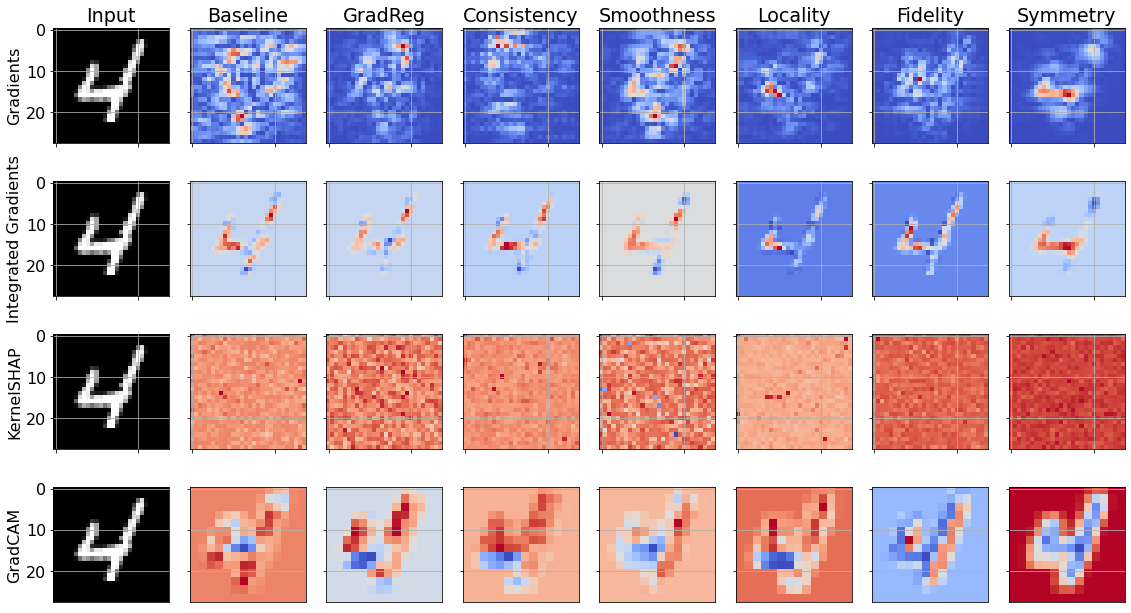

In [109]:
plt.rc("font", size=16)
plt.rc("axes", labelsize=16)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("legend", fontsize=16)
plt.rc("lines", markersize=16)
plt.rcParams['axes.grid'] = True

fig, axs = plt.subplots(nrows=4, ncols=8, sharey = True, sharex=True, figsize=(16,9), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
#fig.text(0.003, 0.5, 'Explainability Constraints', va='center', rotation='vertical')
#fig.suptitle('Sharing both axes')
axs[0,0].imshow(imgs[i2].squeeze().cpu().numpy(), cmap="gray")
axs[0,0].set_ylabel('Gradients')
axs[0,1].imshow(battr1.cpu().numpy(), cmap="coolwarm")
axs[0,2].imshow(rattr1.cpu().numpy(), cmap="coolwarm")
axs[0,3].imshow(cattr1.cpu().numpy(), cmap="coolwarm")
axs[0,4].imshow(stattr1.cpu().numpy(), cmap="coolwarm")
axs[0,5].imshow(lattr1.cpu().numpy(), cmap="coolwarm")
axs[0,6].imshow(fattr1.cpu().numpy(), cmap="coolwarm")
axs[0,7].imshow(syattr1.cpu().numpy(), cmap="coolwarm")
axs[1,0].imshow(imgs[i2].squeeze().cpu().numpy(), cmap="gray")
axs[1,0].set_ylabel('Integrated Gradients')
axs[1,1].imshow(battr2.cpu().numpy(), cmap="coolwarm")
axs[1,2].imshow(rattr2.cpu().numpy(), cmap="coolwarm")
axs[1,3].imshow(cattr2.cpu().numpy(), cmap="coolwarm")
axs[1,4].imshow(stattr2.cpu().numpy(), cmap="coolwarm")
axs[1,5].imshow(lattr2.cpu().numpy(), cmap="coolwarm")
axs[1,6].imshow(fattr2.cpu().numpy(), cmap="coolwarm")
axs[1,7].imshow(syattr2.cpu().numpy(), cmap="coolwarm")
axs[2,0].imshow(imgs[i2].squeeze().cpu().numpy(), cmap="gray")
axs[2,0].set_ylabel('KernelSHAP')
axs[2,1].imshow(battr3.cpu().numpy(), cmap="coolwarm")
axs[2,2].imshow(rattr3.cpu().numpy(), cmap="coolwarm")
axs[2,3].imshow(cattr3.cpu().numpy(), cmap="coolwarm")
axs[2,4].imshow(stattr3.cpu().numpy(), cmap="coolwarm")
axs[2,5].imshow(lattr3.cpu().numpy(), cmap="coolwarm")
axs[2,6].imshow(fattr3.cpu().numpy(), cmap="coolwarm")
axs[2,7].imshow(syattr3.cpu().numpy(), cmap="coolwarm")
axs[3, 0].imshow(imgs[i2].squeeze().cpu().numpy(), cmap="gray")
axs[3,0].set_ylabel('GradCAM')
axs[3,1].imshow(battr4.cpu().detach().numpy(), cmap="coolwarm")
axs[3,2].imshow(rattr4.cpu().detach().numpy(), cmap="coolwarm")
axs[3,3].imshow(cattr4.cpu().detach().numpy(), cmap="coolwarm")
axs[3,4].imshow(stattr4.cpu().detach().numpy(), cmap="coolwarm")
axs[3,5].imshow(lattr4.cpu().detach().numpy(), cmap="coolwarm")
axs[3,6].imshow(fattr4.cpu().detach().numpy(), cmap="coolwarm")
axs[3,7].imshow(syattr4.cpu().detach().numpy(), cmap="coolwarm")
axs[0,0].title.set_text('Input')
axs[0,1].title.set_text('Baseline')
axs[0,2].title.set_text('GradReg')
axs[0,3].title.set_text('Consistency')
axs[0,4].title.set_text('Smoothness')
axs[0,5].title.set_text('Locality')
axs[0,6].title.set_text('Fidelity')
axs[0,7].title.set_text('Symmetry')

axs[3,0].axes.xaxis.set_visible(False)
axs[3,1].axes.xaxis.set_visible(False)
axs[3,2].axes.xaxis.set_visible(False)
axs[3,3].axes.xaxis.set_visible(False)
axs[3,4].axes.xaxis.set_visible(False)
axs[3,5].axes.xaxis.set_visible(False)
axs[3,6].axes.xaxis.set_visible(False)
axs[3,7].axes.xaxis.set_visible(False)


plt.tight_layout()
plt.savefig(os.path.join(outfolder, "saliency_mnist3.pdf"), bbox_inches="tight", dpi=1100)
plt.show()

In [42]:
i1 = 7 
i2 = 111
i3 = 78
i4 = 56

In [18]:
battr0 = bgrad.attribute(imgs[i1], target=lbls[i1].item())
battr0 = battr0.squeeze()
rattr0 = rgrad.attribute(imgs[i1], target=lbls[i1].item())
rattr0 = rattr0.squeeze()
lattr0 = lgrad.attribute(imgs[i1], target=lbls[i1].item())
lattr0 = lattr0.squeeze()
stattr0 = stgrad.attribute(imgs[i1], target=lbls[i1].item())
stattr0 = stattr0.squeeze()
fattr0 = fgrad.attribute(imgs[i1], target=lbls[i1].item())
fattr0 = fattr0.squeeze()
cattr0 = cgrad.attribute(imgs[i1], target=lbls[i1].item())
cattr0 = cattr0.squeeze()
syattr0 = sygrad.attribute(imgs[i1], target=lbls[i1].item())
syattr0 = syattr0.squeeze()

battr1 = bgrad.attribute(imgs[i2], target=lbls[i2].item())
battr1 = battr1.squeeze()
rattr1 = rgrad.attribute(imgs[i2], target=lbls[i2].item())
rattr1 = rattr1.squeeze()
lattr1 = lgrad.attribute(imgs[i2], target=lbls[i2].item())
lattr1 = lattr1.squeeze()
stattr1 = stgrad.attribute(imgs[i2], target=lbls[i2].item())
stattr1 = stattr1.squeeze()
fattr1 = fgrad.attribute(imgs[i2], target=lbls[i2].item())
fattr1 = fattr1.squeeze()
cattr1 = cgrad.attribute(imgs[i2], target=lbls[i2].item())
cattr1 = cattr1.squeeze()
syattr1 = sygrad.attribute(imgs[i2], target=lbls[i2].item())
syattr1 = syattr1.squeeze()

battr2 = bgrad.attribute(imgs[i3], target=lbls[i3].item())
battr2 = battr2.squeeze()
rattr2 = rgrad.attribute(imgs[i3], target=lbls[i3].item())
rattr2 = rattr2.squeeze()
lattr2 = lgrad.attribute(imgs[i3], target=lbls[i3].item())
lattr2 = lattr2.squeeze()
stattr2 = stgrad.attribute(imgs[i3], target=lbls[i3].item())
stattr2 = stattr2.squeeze()
fattr2 = fgrad.attribute(imgs[i3], target=lbls[i3].item())
fattr2 = fattr2.squeeze()
cattr2 = cgrad.attribute(imgs[i3], target=lbls[i3].item())
cattr2 = cattr2.squeeze()
syattr2 = sygrad.attribute(imgs[i3], target=lbls[i3].item())
syattr2 = syattr2.squeeze()

battr3 = bgrad.attribute(imgs[i4], target=lbls[i4].item())
battr3 = battr3.squeeze()
rattr3 = rgrad.attribute(imgs[i4], target=lbls[i4].item())
rattr3 = rattr3.squeeze()
lattr3 = lgrad.attribute(imgs[i4], target=lbls[i4].item())
lattr3 = lattr3.squeeze()
stattr3 = stgrad.attribute(imgs[i4], target=lbls[i4].item())
stattr3 = stattr3.squeeze()
fattr3 = fgrad.attribute(imgs[i4], target=lbls[i4].item())
fattr3 = fattr3.squeeze()
cattr3 = cgrad.attribute(imgs[i4], target=lbls[i4].item())
cattr3 = cattr3.squeeze()
syattr3 = sygrad.attribute(imgs[i4], target=lbls[i4].item())
syattr3 = syattr3.squeeze()

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


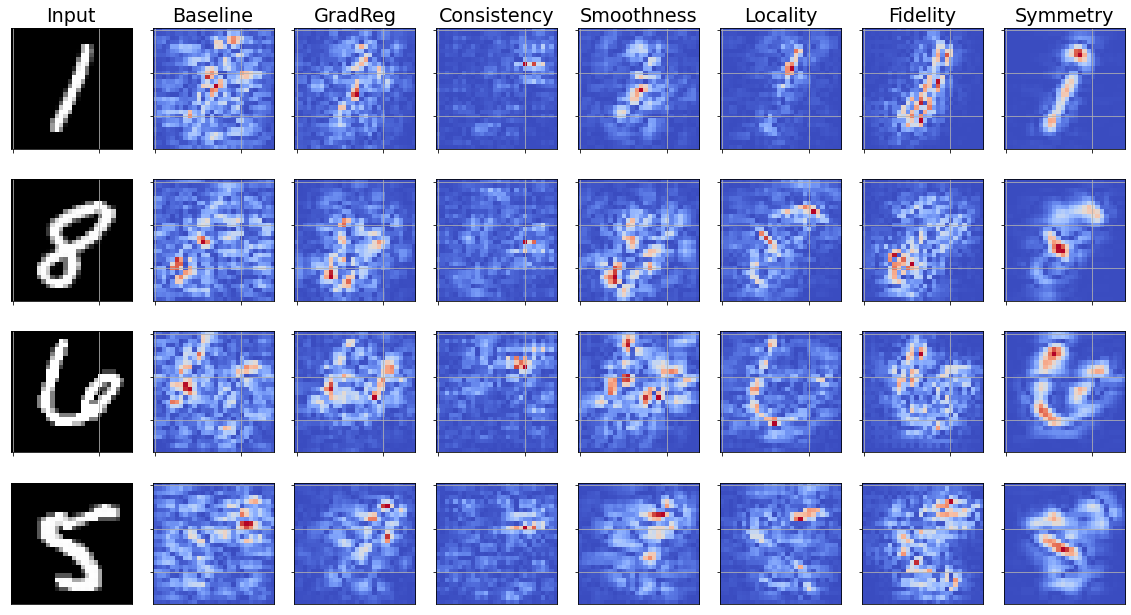

In [19]:
plt.rc("font", size=16)

fig, axs = plt.subplots(nrows=4, ncols=8, sharey = True, sharex=True, figsize=(16,9), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
#fig.text(0.003, 0.5, 'Explainability Constraints', va='center', rotation='vertical')
#fig.suptitle('Sharing both axes')
axs[0,0].imshow(imgs[i1].squeeze().cpu().numpy(), cmap="gray")
axs[0,1].imshow(battr0.cpu().numpy(), cmap="coolwarm")
axs[0,2].imshow(rattr0.cpu().numpy(), cmap="coolwarm")
axs[0,3].imshow(cattr0.cpu().numpy(), cmap="coolwarm")
axs[0,4].imshow(stattr0.cpu().numpy(), cmap="coolwarm")
axs[0,5].imshow(lattr0.cpu().numpy(), cmap="coolwarm")
axs[0,6].imshow(fattr0.cpu().numpy(), cmap="coolwarm")
axs[0,7].imshow(syattr0.cpu().numpy(), cmap="coolwarm")
axs[1,0].imshow(imgs[i2].squeeze().cpu().numpy(), cmap="gray")
axs[1,1].imshow(battr1.cpu().numpy(), cmap="coolwarm")
axs[1,2].imshow(rattr1.cpu().numpy(), cmap="coolwarm")
axs[1,3].imshow(cattr1.cpu().numpy(), cmap="coolwarm")
axs[1,4].imshow(stattr1.cpu().numpy(), cmap="coolwarm")
axs[1,5].imshow(lattr1.cpu().numpy(), cmap="coolwarm")
axs[1,6].imshow(fattr1.cpu().numpy(), cmap="coolwarm")
axs[1,7].imshow(syattr1.cpu().numpy(), cmap="coolwarm")
axs[2,0].imshow(imgs[i3].squeeze().cpu().numpy(), cmap="gray")
axs[2,1].imshow(battr2.cpu().numpy(), cmap="coolwarm")
axs[2,2].imshow(rattr2.cpu().numpy(), cmap="coolwarm")
axs[2,3].imshow(cattr2.cpu().numpy(), cmap="coolwarm")
axs[2,4].imshow(stattr2.cpu().numpy(), cmap="coolwarm")
axs[2,5].imshow(lattr2.cpu().numpy(), cmap="coolwarm")
axs[2,6].imshow(fattr2.cpu().numpy(), cmap="coolwarm")
axs[2,7].imshow(syattr2.cpu().numpy(), cmap="coolwarm")
axs[3, 0].imshow(imgs[i4].squeeze().cpu().numpy(), cmap="gray")
axs[3,1].imshow(battr3.cpu().numpy(), cmap="coolwarm")
axs[3,2].imshow(rattr3.cpu().numpy(), cmap="coolwarm")
axs[3,3].imshow(cattr3.cpu().numpy(), cmap="coolwarm")
axs[3,4].imshow(stattr3.cpu().numpy(), cmap="coolwarm")
axs[3,5].imshow(lattr3.cpu().numpy(), cmap="coolwarm")
axs[3,6].imshow(fattr3.cpu().numpy(), cmap="coolwarm")
axs[3,7].imshow(syattr3.cpu().numpy(), cmap="coolwarm")
axs[0,0].title.set_text('Input')
axs[0,1].title.set_text('Baseline')
axs[0,2].title.set_text('GradReg')
axs[0,3].title.set_text('Consistency')
axs[0,4].title.set_text('Smoothness')
axs[0,5].title.set_text('Locality')
axs[0,6].title.set_text('Fidelity')
axs[0,7].title.set_text('Symmetry')

axs[3,0].axes.xaxis.set_visible(False)
axs[3,1].axes.xaxis.set_visible(False)
axs[3,2].axes.xaxis.set_visible(False)
axs[3,3].axes.xaxis.set_visible(False)
axs[3,4].axes.xaxis.set_visible(False)
axs[3,5].axes.xaxis.set_visible(False)
axs[3,6].axes.xaxis.set_visible(False)
axs[3,7].axes.xaxis.set_visible(False)
axs[0,0].axes.yaxis.set_visible(False)
axs[1,0].axes.yaxis.set_visible(False)
axs[2,0].axes.yaxis.set_visible(False)
axs[3,0].axes.yaxis.set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(outfolder, "saliency_mnist2.pdf"), bbox_inches="tight", dpi=1100)
plt.show()